### Imports

In [215]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Выбор признаков

In [216]:
class FilterSelector:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        scores = []
        for i in tqdm(range(X.shape[1])):
            column = X[:, i].toarray().flatten()
            table = np.array([
                [(y[column == 0] == 0).sum(), (y[column == 0] == 1).sum()],
                [(y[column > 0] == 0).sum(), (y[column > 0] == 1).sum()]
            ])
            expected = table.sum(axis=1).reshape(-1, 1) * table.sum(axis=0) / table.sum()
            expected[expected == 0] = 1e-10
            score = ((table - expected) ** 2 / expected).sum()
            scores.append(score)
        self.top_indices = np.argsort(scores)[-self.k:]

    def transform(self, X):
        return X[:, self.top_indices]


class EmbeddedSelector:
    def __init__(self, model, k):
        self.k = k
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        if hasattr(self.model, "coef_"):
            feature_importances = np.abs(self.model.coef_)
        elif hasattr(self.model, "feature_importances_"):
            feature_importances = self.model.feature_importances_
        else:
            raise ValueError("Incorrect model given")

        self.top_indices = np.argsort(feature_importances)[-self.k:]

    def transform(self, X):
        return X[:, self.top_indices]


class WrapperSelector:
    def __init__(self, model, k):
        self.model = model
        self.k = k

    def fit(self, X, y):
        n_features = X.shape[1]
        features = []
        remaining_features = list(range(n_features))

        for _ in tqdm(range(self.k)):
            if not remaining_features:
                break
            scores = []
            for feature in remaining_features:
                test_features = features + [feature]
                self.model.fit(X[:, test_features], y)
                scores.append(self.model.score(X[:, test_features], y))

            best_feature = remaining_features[np.argmax(scores)]
            features.append(best_feature)
            remaining_features.remove(best_feature)

        self.features = features

    def transform(self, X):
        return X[:, self.features]

### Data

In [141]:
sms = pd.read_csv('SMS.tsv', sep='\t')
vectorizer = CountVectorizer()
y = sms['class'].map({'ham': 0, 'spam': 1})
X = vectorizer.fit_transform(sms['text'])
feature_names = vectorizer.get_feature_names()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


def get_words(indices):
    return [feature_names[i] for i in indices]

### Сравнение методов выбора признаков

In [111]:
features_number = 30

In [191]:
filterSelector = FilterSelector(k=features_number)
filterSelector.fit(X_train, y_train)

100%|██████████| 8713/8713 [00:23<00:00, 377.03it/s]


In [217]:
embeddedSelector = EmbeddedSelector(model=GradientBoostingClassifier(n_estimators=100), k=features_number)
embeddedSelector.fit(X_train, y_train)

In [145]:
wrapper_selector = WrapperSelector(model=LogisticRegression(), k=features_number)
wrapper_selector.fit(X_train, y_train)

100%|██████████| 30/30 [1:40:58<00:00, 201.94s/it]


### Библиотечные реализации

In [208]:
miSelector = SelectKBest(score_func=mutual_info_classif, k=features_number)
miSelector.fit(X_train, y_train)
SelectFromModelSelector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=features_number)
SelectFromModelSelector.fit(X_train, y_train)

# RFESelector = RFE(estimator=LogisticRegression(), n_features_to_select=1)
# RFESelector.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(), max_features=30)

In [218]:
for method_name, indices in zip(
        ["My filter", "My embedded", "My wrapper", "MI filter", "Select from model"],
        [filterSelector.top_indices, embeddedSelector.top_indices, wrapper_selector.features,
         miSelector.get_support(indices=True), SelectFromModelSelector.get_support(indices=True)]
):
    print(method_name, ":", get_words(indices))

My filter : ['nokia', 'cash', '500', 'tone', 'now', 'co', 'service', '16', '50', 'cs', 'com', 'won', 'win', 'reply', 'your', '18', 'or', 'urgent', 'text', 'to', 'uk', '150p', 'stop', 'prize', 'www', 'mobile', 'claim', 'free', 'txt', 'call']
My embedded : ['now', '50', 'chat', 'hot', 'or', 'tones', '18', 'from', 'http', 'my', 'll', 'cash', 'your', 'to', 'com', 'reply', 'win', 'service', 'later', 'mobile', 'stop', '150p', 'uk', 'text', 'claim', 'www', 'me', 'free', 'txt', 'call']
My wrapper : ['txt', 'call', 'me', 'www', 'later', 'uk', '16', '150p', 'service', 'at', 'claim', 'chat', 'my', 'gt', 'latest', 'ringtone', 'pls', 'can', 'end', 'he', 'ask', 'bloomberg', '0800', 'might', 'oh', 'freemsg', 'sir', '0871750', '5pm', '88066']
MI filter : ['150p', '16', '18', '50', '500', 'call', 'cash', 'claim', 'co', 'com', 'cs', 'free', 'from', 'mobile', 'now', 'or', 'prize', 'reply', 'service', 'stop', 'text', 'to', 'tone', 'txt', 'uk', 'urgent', 'win', 'won', 'www', 'your']
Select from model : ['1

### Классификация

100%|██████████| 5/5 [00:06<00:00,  1.24s/it]


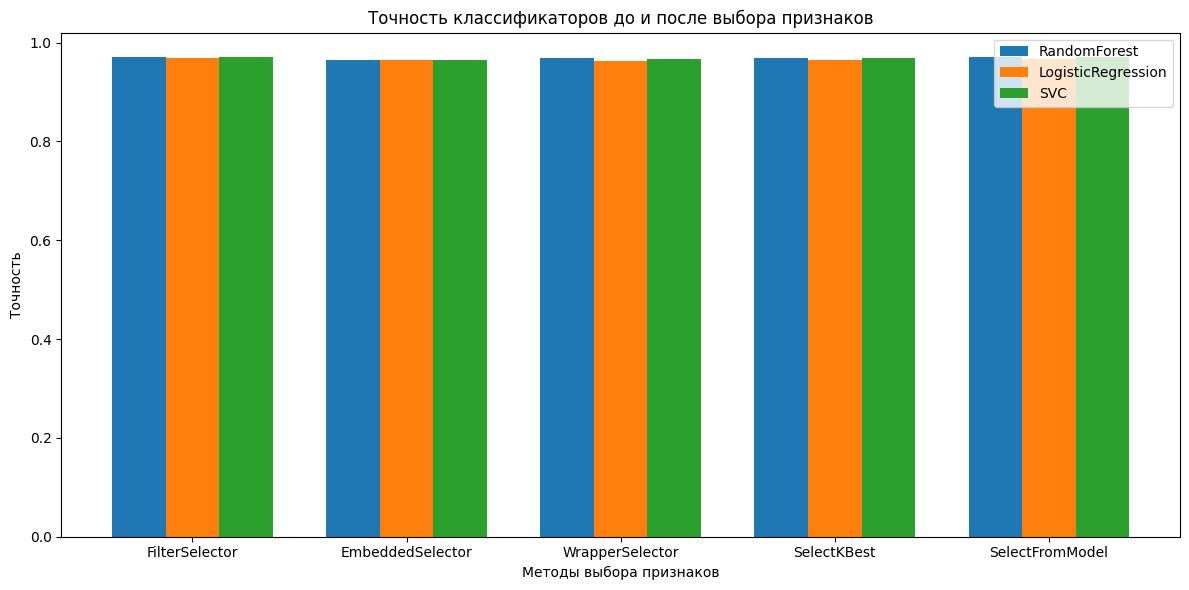

In [219]:
classifiers = {
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVC': SVC()
}

accuracies = {clf_name: [] for clf_name in classifiers.keys()}

methods = {
    'FilterSelector': filterSelector,
    'EmbeddedSelector': embeddedSelector,
    'WrapperSelector': wrapper_selector,
    'SelectKBest': miSelector,
    'SelectFromModel': SelectFromModelSelector
}

for method_name, method in tqdm(methods.items()):
    X_train_selected = method.transform(X_train)
    X_test_selected = method.transform(X_test)

    for clf_name, clf in classifiers.items():
        clf.fit(X_train_selected, y_train)
        y_pred = clf.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies[clf_name].append(accuracy)

x_labels = list(methods.keys())
x = np.arange(len(x_labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))

for i, (clf_name, acc) in enumerate(accuracies.items()):
    plt.bar(x + i * bar_width, acc, width=bar_width, label=clf_name)

plt.xlabel('Методы выбора признаков')
plt.ylabel('Точность')
plt.title('Точность классификаторов до и после выбора признаков')
plt.xticks(x + bar_width, x_labels)
plt.legend()
plt.tight_layout()
plt.show()

### Clustering (KMeans)

In [220]:
class MyKMeans:
    def __init__(self, k, max_iter=300, random_state=42):
        self.k = k
        self.max_iter = max_iter
        self.random_state = random_state

    def fit(self, X):
        np.random.seed(self.random_state)
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]

        for _ in range(self.max_iter):
            distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
            self.labels = np.argmin(distances, axis=1)

            new_centroids = []
            for i in range(self.k):
                cluster_points = X[self.labels == i]
                if len(cluster_points) == 0:
                    new_centroids.append(X[np.random.choice(X.shape[0])])
                else:
                    new_centroids.append(cluster_points.mean(axis=0))
            new_centroids = np.array(new_centroids)

            if np.all(self.centroids == new_centroids):
                break

            self.centroids = new_centroids

    def predict(self, X):
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)


In [221]:
def visualize(X, y, clusters, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())

    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    X_tsne = tsne.fit_transform(X.toarray())

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)

    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.6, label='Clusters')
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.6, marker='x', label='True Labels')
    plt.title(f"{title} - PCA")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=clusters, cmap='viridis', alpha=0.6, label='Clusters')
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', alpha=0.6, marker='x', label='True Labels')
    plt.title(f"{title} - t-SNE")
    plt.legend()

    plt.show()

In [222]:
X_train_filtered = filterSelector.transform(X_train)

In [223]:
kmeans = MyKMeans(k=2)
X_before = X_train.toarray()
kmeans.fit(X_before)
clusters_before = kmeans.predict(X_before)
score_before = silhouette_score(X_before, clusters_before)

X_after = X_train_filtered.toarray()
kmeans.fit(X_after)
clusters_after = kmeans.predict(X_after)
score_after = silhouette_score(X_after, clusters_after)

In [224]:
print(f"Silhouette score до выбора признаков: {score_before}")
print(f"Silhouette score после выбора признаков: {score_after}")

Silhouette score до выбора признаков: 0.22630099930171468
Silhouette score после выбора признаков: 0.49421894813864214


In [225]:
ari_before = adjusted_rand_score(y_train, clusters_before)
ari_after = adjusted_rand_score(y_train, clusters_after)
print("Adjusted Rand Index до выбора признаков:", ari_before)
print("Adjusted Rand Index после выбора признаков:", ari_after)

Adjusted Rand Index до выбора признаков: 0.0366150970388416
Adjusted Rand Index после выбора признаков: 0.14056580657821455


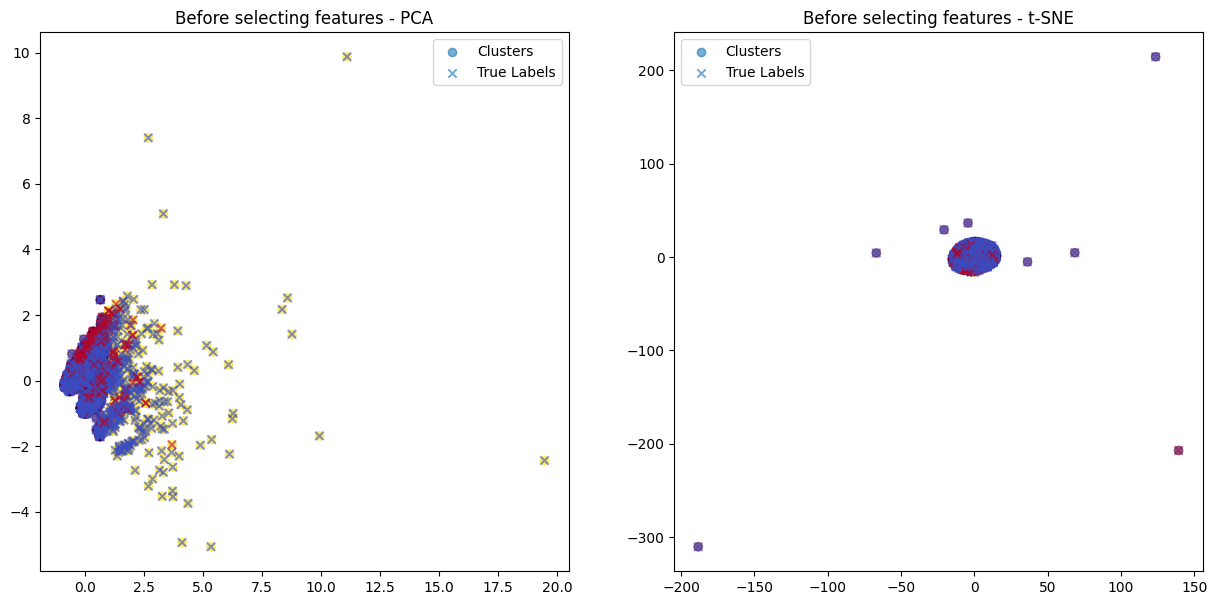

In [226]:
visualize(X_train, y_train, clusters_before, "Before selecting features")

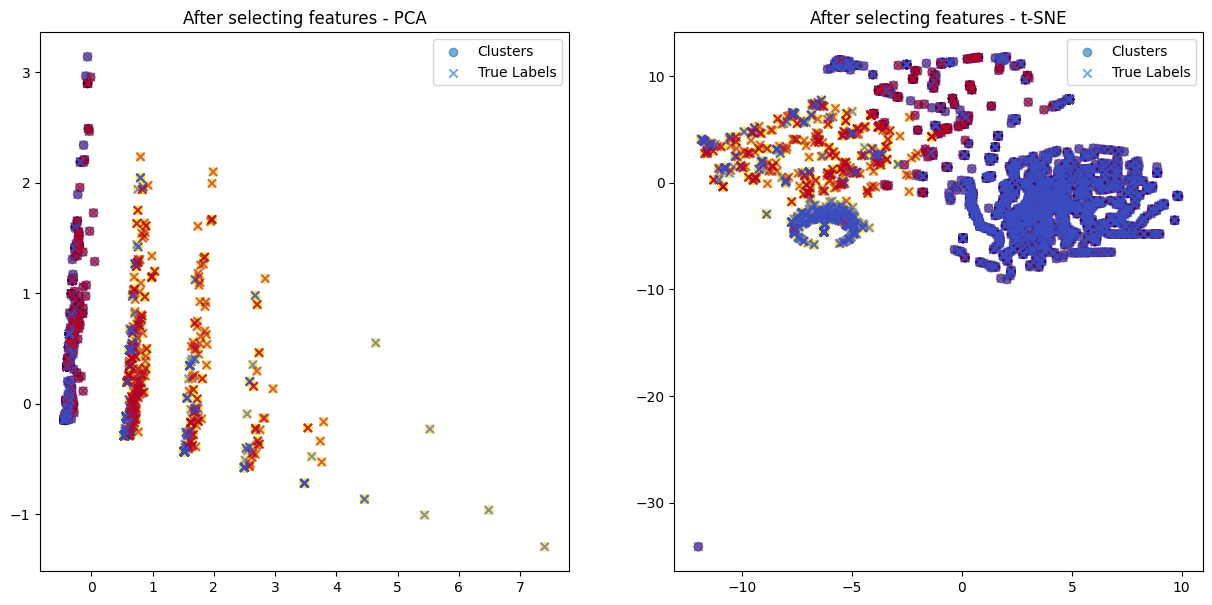

In [227]:
visualize(X_train_filtered, y_train, clusters_after, "After selecting features")